In [0]:
%tensorflow_version 2.0.0

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0.0`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5080027117175960151
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7221116679252138869
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4063823523043516925
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7470045594
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7971256355794494914
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [0]:
#mount your own drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Getting all pip packages
import subprocess
import sys

reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==') for r in reqs.split()]


In [0]:
#installing tensorflow-datasets==2.1.0
if ['tensorflow-datasets', '2.1.0'] not in installed_packages:
  !pip uninstall tensorflow-datasets
  !pip install tensorflow-datasets 

In [0]:
#installing tensorflow-addons==0.6.0
if ['tensorflow-addons', '0.6.0'] not in installed_packages:
  !pip uninstall tensorflow-addons
  !pip install tensorflow-addons==0.6.0
  #Please Restart Runtime

In [0]:
import sys
!{sys.executable} -m pip install tf-keras-vis

In [0]:
#Following creates a directory, downloads the file and unzips it. 
if os.path.isdir('gdrive/My Drive/celeb_a/2.0.0'):
    print('Found dataset' ) #os.listdir('gdrive/My Drive/celeb_a/2.0.0')
else:
    os.makedirs('gdrive/My Drive/celeb_a')
    !wget -O gdrive/My\ Drive/celeb_a/2.0.0.zip https://cs109b2020.s3.amazonaws.com/2.0.0.zip
    !unzip gdrive/My\ Drive/celeb_a/2.0.0.zip  -d gdrive/My\ Drive/celeb_a/

Found dataset


In [0]:
%tensorflow_version 2.0
import tensorflow as tf

tf.keras.backend.clear_session()

import numpy as np

from PIL import Image

from matplotlib import pyplot
import matplotlib.pylab as plt 
from matplotlib import cm

from scipy.signal import convolve2d
%matplotlib inline
#plt.style.use('dark_background')

import os

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow import keras

#from keras.models import load_model
from tensorflow.keras.models import load_model

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import certifi
import urllib3  # For handling https certificate verification 
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds
import tensorflow_addons as tfa


# This line will download the CelebA dataset. The download will only happen the first time you ever run this cell.
train_celeb, test_celeb = tfds.load('celeb_a', split=['train', 'test'], shuffle_files=False, data_dir = 'gdrive/My Drive/', download=False)

In [0]:
# You may use the following two functions
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def rot_resize(img, deg):
    rotimg = ndimage.rotate(img, deg, reshape=False, order=3)
    rotimg = np.clip(rotimg, 0., 1.)
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

################################################################
# Don't manually invoke these functions; they are for Dataset 
# pipelining that is already done for you.
################################################################
def tf_rot_resize(img, deg):
    """Dataset pipe that rotates an image and resizes it to 140x120"""
    rotimg = tfa.image.rotate(img, deg/180.*np.pi, interpolation="BILINEAR")
    rotimg = tf.image.resize_with_crop_or_pad(rotimg,140,120)
    return rotimg

def tf_random_rotate_helper(image):
    """Dataset pipe that normalizes image to [0.,1.] and rotates by a random
    amount of degrees in [-60.,60.], returning an (input,target) pair consisting
    of the rotated and resized image and the degrees it has been rotated by."""
    image = normalize_image(image)
    deg = tf.random.uniform([],-60.,60.)
    return (tf_rot_resize(image,deg), deg)  # (data, label)

def tf_random_rotate_image(element):
    """Given an element drawn from the CelebA dataset, this returns a rotated
    image and the amount it has been rotated by, in degrees."""
    image = element['image']
    image, label = tf_random_rotate_helper(image)
    image.set_shape((140,120,3))
    return image, label
################################################################

# 4.1 Answer

* Datasets are dictionaries that can store tensors and other data such as the response variable. This means that once we have our model; we may pass a Dataset instance directly to the methods fit(), evaluate(), and predict()

* Batch_size and take_size commands also allow us greater flexibility in processing data.

In [0]:
# Pipeline for creating randomly rotated images with their target labels being 
# the amount they were rotated, in degrees.
train_rot_ds = train_celeb.map(tf_random_rotate_image)
test_rot_ds = test_celeb.map(tf_random_rotate_image)

# 4.2 Answer

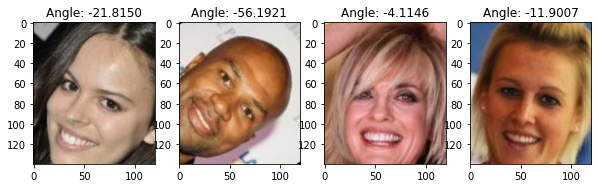

In [0]:
fig, axes = plt.subplots(1,4, figsize = (10,10))

for i, (img, label) in enumerate(train_rot_ds.take(4)):
  axes[i].imshow(img)
  axes[i].set_title(f'Angle: {label:.4f}')
  axes[i].set_axis_off


# 4.3 Answer

* A Dropout layer sets a fraction of its inputs to zero; the fraction is specified in the call
* Dropout helps to prevent overfitting, making the learned filters more generalised since only a fraction of the inputs are exposed to the data for the iteration.
* For our data using dropouts is a good idea since it would mean that subject to other parameters being accurately specified, the network would be able to perform on unseen images. This is especially important for real life applications in a papparazzi world.


# 4.4 Build a model

In [0]:
# Build model

model = Sequential(name = 'rot_model')

model.add(Conv2D(32, (5, 5), activation='relu', padding = 'valid', input_shape=(140, 120, 3), name = 'rm_cnn1'))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'valid', name = 'rm_cnn2'))
model.add(MaxPooling2D((2, 2), name = 'rm_pool1'))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'valid', name = 'rm_cnn3'))
model.add(Dropout(0.10, name = 'rm_dropout1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'valid', name = 'rm_cnn4'))
model.add(MaxPooling2D((2, 2), name = 'rm_pool2'))

model.add(Conv2D(128, (3, 3), activation='relu', padding = 'valid', name = 'rm_cnn5'))
model.add(Dropout(0.10, name = 'rm_dropout2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'valid', name = 'rm_cnn6'))
model.add(MaxPooling2D((2, 2), name = 'rm_pool3'))

model.add(Flatten(name = 'rm_flat1'))

model.add(Dense(512, activation='relu', name = 'rm_dense1'))
model.add(Dense(1, activation='linear', name = 'rm_dense2'))
model.summary()


Model: "rot_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rm_cnn1 (Conv2D)             (None, 136, 116, 32)      2432      
_________________________________________________________________
rm_cnn2 (Conv2D)             (None, 134, 114, 32)      9248      
_________________________________________________________________
rm_pool1 (MaxPooling2D)      (None, 67, 57, 32)        0         
_________________________________________________________________
rm_cnn3 (Conv2D)             (None, 65, 55, 64)        18496     
_________________________________________________________________
rm_dropout1 (Dropout)        (None, 65, 55, 64)        0         
_________________________________________________________________
rm_cnn4 (Conv2D)             (None, 63, 53, 64)        36928     
_________________________________________________________________
rm_pool2 (MaxPooling2D)      (None, 31, 26, 64)        0 

In [0]:
# Compile model

loss = 'mse'

optimaz = Adam(lr = 0.001)

metrics = ['mse'] 

model.compile(optimizer = optimaz, loss = loss, metrics=metrics)
model.summary()

Model: "rot_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rm_cnn1 (Conv2D)             (None, 136, 116, 32)      2432      
_________________________________________________________________
rm_cnn2 (Conv2D)             (None, 134, 114, 32)      9248      
_________________________________________________________________
rm_pool1 (MaxPooling2D)      (None, 67, 57, 32)        0         
_________________________________________________________________
rm_cnn3 (Conv2D)             (None, 65, 55, 64)        18496     
_________________________________________________________________
rm_dropout1 (Dropout)        (None, 65, 55, 64)        0         
_________________________________________________________________
rm_cnn4 (Conv2D)             (None, 63, 53, 64)        36928     
_________________________________________________________________
rm_pool2 (MaxPooling2D)      (None, 31, 26, 64)        0 

# 4.5 Train the model

In [0]:
# specify parameters and fit model

batch_size = 500
n_epoch = 21

earlystopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.003, patience = 3, verbose = 1)
modelcheck_cb = tf.keras.callbacks.ModelCheckpoint(filepath = "q4_celeb.h5", monitor = 'mse', verbose = 1, save_best_only = True)

call = [earlystopping_cb, modelcheck_cb]


In [0]:
%%time

history = model.fit(train_rot_ds.batch(batch_size), validation_data = test_rot_ds.batch(batch_size), epochs = n_epoch, callbacks = call)

Epoch 1/21
    326/Unknown - 707s 2s/step - loss: 10.4994 - mse: 10.5005
Epoch 00001: mse improved from inf to 10.50049, saving model to q4_celeb.h5
326/326 [==============================] - 787s 2s/step - loss: 10.4994 - mse: 10.5005 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/21
39/40 [============================>.] - ETA: 2s - loss: 9.3134 - mse: 9.3134
Epoch 00002: mse improved from 10.50049 to 9.09406, saving model to q4_celeb.h5
326/326 [==============================] - 842s 3s/step - loss: 9.1203 - mse: 9.0941 - val_loss: 16.7258 - val_mse: 16.7316
Epoch 3/21
39/40 [============================>.] - ETA: 2s - loss: 8.0544 - mse: 8.0544
Epoch 00003: mse improved from 9.09406 to 7.61201, saving model to q4_celeb.h5
326/326 [==============================] - 793s 2s/step - loss: 7.6649 - mse: 7.6120 - val_loss: 12.6381 - val_mse: 12.6350
Epoch 4/21
39/40 [============================>.] - ETA: 2s - loss: 7.9509 - mse: 7.9509
Epoch 00004: mse improved from 7.61201 to 6.9

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

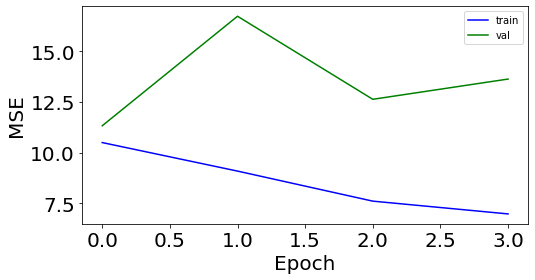

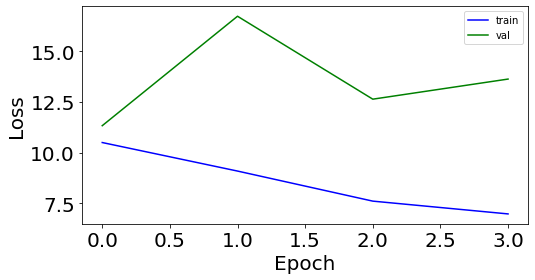

In [0]:
# Plot the loss and accuracy (both train and test)
# As can be seen the model ,eets early stopping criteria after 4 epochs.

def print_history(history):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot((history.history['mse']), 'b', label='train')
    ax.plot((history.history['val_mse']), 'g' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'MSE', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)

    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot((history.history['loss']), 'b', label='train')
    ax.plot((history.history['val_loss']), 'g' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=20)
    ax.set_ylabel(r'Loss', fontsize=20)
    ax.legend()
    ax.tick_params(labelsize=20)
    plt.show();
    
print_history(history)

# 4.6 Conceptual Question

* If we only save the weights then we need to ensure that the weigths are restored to a model that has the exact same structure as the original model.
* Saving weights allows us to continue from where we left off even if we are working on a different instance.
* Saving an entire model ensures that the architecture of the model is replicated and that we can pick up from where the model was left off.
* A saved model might be larger in size and would require us to be concious of the overall environment and other dependencies

# 4.7 Save and load

In [0]:
# Save the weights
model.save_weights('../rot_mod_weights')


In [0]:
# Restore the weights
model.load_weights('../rot_mod_weights')


# 4.8 Test Performance

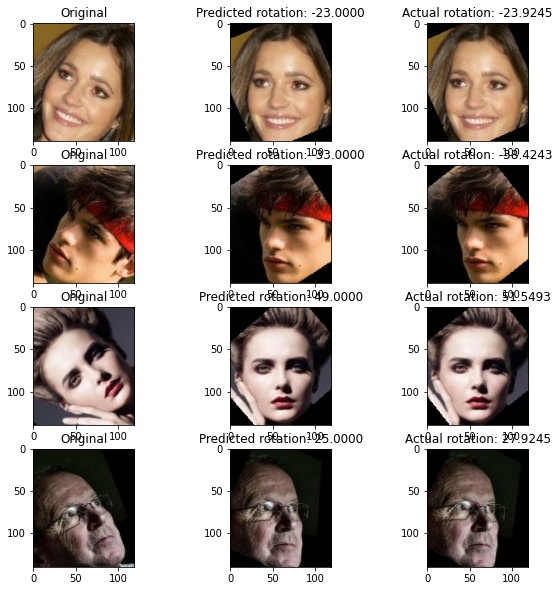

In [0]:
fig, axes = plt.subplots(4,3, figsize = (10,10))

for i, (img, label) in enumerate(test_rot_ds.take(4)):
  image = img.numpy()
  #print(image.shape)
  image_pred = np.expand_dims(image, axis = 0)
  pred = model.predict(image_pred, verbose = 0)
  #print(pred), type(pred))
  axes[i][0].imshow(image)
  axes[i][0].set_title('Original')
  axes[i][1].imshow(rot_resize(image, (-1*int(pred))))
  axes[i][1].set_title(f'Predicted rotation: {int(pred):.4f}')
  axes[i][2].imshow(rot_resize(image, (-1*label)))
  axes[i][2].set_title(f'Actual rotation: {label:.4f}')


# 4.9 Visualizing Attention.

In [0]:
def test_img(tf_ds_val):
  # to get images for generating gradcam and saliency
  for elem in tf_ds_val:
    img = elem[0].numpy()
    lab = int(elem[1])
    #print(lab)
    #print(img.shape)
  return img,lab

In [0]:
img1, lab1 = test_img(test_rot_ds.take(1))
img2, lab2 = test_img(test_rot_ds.take(1))
img3, lab3 = test_img(test_rot_ds.take(1))
img4, lab4 = test_img(test_rot_ds.take(1))

In [0]:
def model_modifier(m):
    #m.layers[-1].activation = tf.keras.activations.linear
    pass

In [0]:
img_batch = (np.expand_dims(img1,0))

In [0]:
# Create Saliency object
saliency = Saliency(model, model_modifier)

# Define loss function. Pass it the correct class label.
loss = lambda output: tf.keras.backend.mean((output-label)**2)

saliency_map = saliency(loss, img_batch)

saliency_map = normalize(saliency_map)

In [0]:
gradcam = Gradcam(model, model_modifier)

# Generate heatmap with GradCAM
cam = gradcam(loss, img_batch)
cam = normalize(cam)

heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)


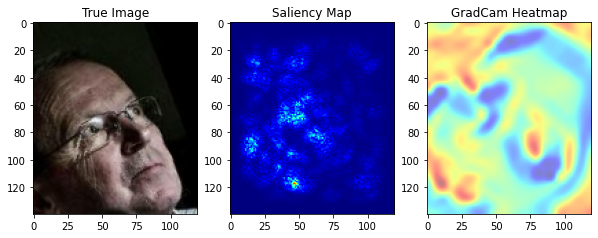

In [0]:
img_batch = np.squeeze(img_batch)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('True Image')
ax[1].imshow(saliency_map[0], cmap='jet')
ax[1].set_title('Saliency Map')
ax[2].imshow(heatmap, cmap='jet', alpha=0.5)
ax[2].set_title('GradCam Heatmap');

* The network appears to focus on color transitions and areas illuminated by light

# 4.10

* Correct an image of your choosing.
* Find an image or image(s) (not from the provided test/training sets), or make your own. You may rotate it yourself up to ±60∘, or the face can already be naturally rotated. 
* Resize and crop the image to 140px by 120px, load it here, and normalize it to [0.,1.] (you may use the provided normalize_image function) and use your network to correct it. 
* I found that my network was a very effective "un-confuser": 

(140, 120, 3)

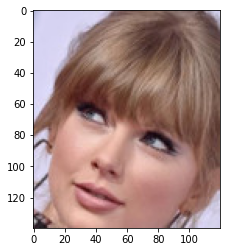

In [53]:
tswift = plt.imread("gdrive/My Drive/tswift.jpg")
plt.imshow(tswift)
tswift.shape

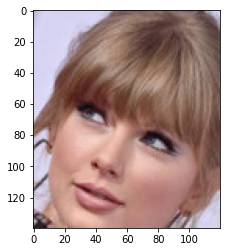

In [61]:
tswift_norm = image.astype('float32')/255
plt.imshow(tswift_norm)

Text(0.5, 1.0, 'Predicted rotation: -19.0000')

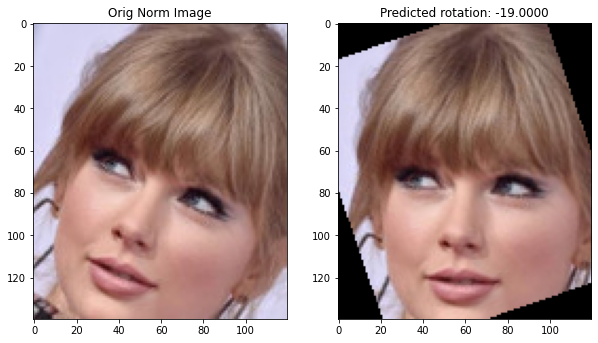

In [64]:
tsift_pred = np.expand_dims(tswift_norm, axis = 0)
pred = model.predict(tsift_pred, verbose = 0)

fig, axes = plt.subplots(1,2, figsize = (10,10))

axes[0].imshow(tswift_norm)
axes[0].set_title('Orig Norm Image')
axes[1].imshow(rot_resize(tswift_norm, (-1*int(pred))))
axes[1].set_title(f'Predicted rotation: {int(pred):.4f}')
